In [0]:
from google.colab import drive
drive.mount('/content/drive')

Data Preprocessing

In [0]:
import pandas as pd
df=pd.read_csv('drive/My Drive/Colab Notebooks/Final Project/Task 2/train.csv')
# df=pd.read_csv('train.csv')   # my PC
df['label'] = df['label'].astype(str)
df.head()

In [0]:
traindf = df.sample(frac=0.75, random_state=777)   # 隨機將train.csv裡的檔案分成train:validation=3:1
validf = df.drop(traindf.index)

display(traindf.head())
display(validf.head())
print('各DataFrame 大小:', len(df), len(traindf), len(validf))

In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "drive/My Drive/Colab Notebooks/Final Project/Task 2"   # Colab 路徑
# base_dir = os.getcwd()   # My PC路徑 (notebook當前路徑)
train_dir = os.path.join(base_dir, 'train_img')
valid_dir = os.path.join(base_dir, 'train_img')
test_dir = os.path.join(base_dir, 'test_img')

BATCH_SIZE = 10

train_datagen = ImageDataGenerator(  # data augmentation
        rotation_range=15,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255., 
        # validation_split=0.25
)
train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_dir,
    x_col='image',
    y_col='label',
#     has_ext=False,
#     subset="training",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    target_size=(224, 224)
)

vaild_datagen = ImageDataGenerator(
        rescale=1./255.
)
validation_generator = vaild_datagen.flow_from_dataframe( 
    dataframe=validf,
    directory=valid_dir,
    x_col='image',
    y_col='label',
#     has_ext=False,
#     subset="validation",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    target_size=(224, 224)
)

# 
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=False,
    class_mode=None
)

Model

In [0]:
from keras.applications.resnet_v2 import ResNet50V2

base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
from keras import optimizers

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

Training

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/20
50/50 [==============================] - 21s 427ms/step - loss: 0.6021 - acc: 0.7360 - val_loss: 0.6770 - val_acc: 0.7560
Epoch 2/20
50/50 [==============================] - 11s 212ms/step - loss: 0.5304 - acc: 0.7980 - val_loss: 0.6499 - val_acc: 0.7420
Epoch 3/20
50/50 [==============================] - 11s 215ms/step - loss: 0.4905 - acc: 0.8140 - val_loss: 1.0694 - val_acc: 0.7480
Epoch 4/20
50/50 [==============================] - 10s 209ms/step - loss: 0.5639 - acc: 0.7860 - val_loss: 1.1175 - val_acc: 0.7420
Epoch 5/20
50/50 [==============================] - 11s 220ms/step - loss: 0.5002 - acc: 0.8180 - val_loss: 1.2944 - val_acc: 0.7500
Epoch 6/20
50/50 [==============================] - 11s 215ms/step - loss: 0.5129 - acc: 0.7920 - val_loss: 0.9230 - val_acc: 0.7800
Epoch 7/20
50/50 [==============================] - 11s 218ms/step - loss: 0.5557 - acc: 0.7600 - val_loss: 0.6927 - val_acc: 0.7800
Epoch 8/20
50/50 [==============================] - 11s 217ms/step - 

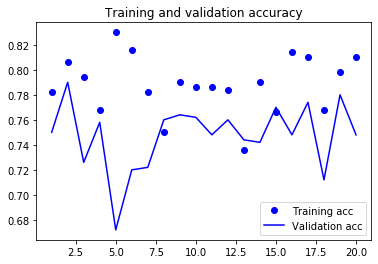

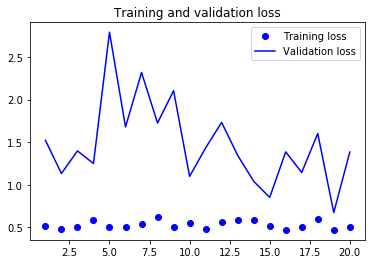

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('accu.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')

plt.show()

Test

In [0]:
def to_class(i):              # 小數轉成整數
    new = list()
    for e in i:
        if e >= 0.5:
            new.append(1)
        else:
            new.append(0)
    return new

In [0]:
def revise(x):                  # 改filename (留\\後面的檔名就好)
    return x.split('\\')[1]

In [0]:
pred = model.predict_generator(test_generator)
# print(len(pred))
# print(pred)

classes = to_class(list(pred.reshape(-1)))

filenames = test_generator.filenames    # Get filenames (set shuffle=false in generator is important)

In [0]:
np.array(classes).mean()

In [0]:
# 還沒試 rotation等等
# https://medium.com/@jackycsie/%E5%B0%8F%E6%95%B8%E6%93%9A%E7%9A%84%E9%80%86%E8%A5%B2-c04fee852539
# ReduceLROnPlateau
#　https://hackmd.io/@allen108108/SyCsOIkxB

In [0]:
output = pd.DataFrame(np.array([filenames, classes]).transpose(), columns=['image', 'label'])
output

In [0]:
output['image'] = output['image'].apply(revise)
output

In [0]:
output.to_csv('Result/result7.csv', index=False, encoding='utf-8')

In [0]:
model.save('task2_1218.h5')